In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# Preparing Data

In [2]:
data = pd.read_csv('../data/REMEDY.HE.csv')
data = data.drop(columns=['Adj Close']) 
data.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-02,11.65,12.30,11.65,11.80,20521
1,2020-01-03,12.05,12.05,11.45,11.80,9241
2,2020-01-07,11.80,12.10,11.80,11.95,7571
3,2020-01-08,11.90,12.20,11.80,12.10,15467
4,2020-01-09,12.15,12.70,12.15,12.50,19329


In [3]:
data.shape[0]

1037

In [4]:
# fixing the dtypes
data.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1037 non-null   object 
 1   Open    1037 non-null   float64
 2   High    1037 non-null   float64
 3   Low     1037 non-null   float64
 4   Close   1037 non-null   float64
 5   Volume  1037 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 48.7+ KB


In [6]:
data["Date"] = pd.to_datetime(data["Date"])

In [7]:
# checking missing values
data.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [8]:
# check duplicate
len(data["Date"].unique()) == data.shape[0] # shows count of unique values , which is equal to the total count of data

True

# EDA

In [9]:
data.describe()

,Date,Open,High,Low,Close,Volume
count,1037,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,2022-01-21 10:34:35.988428032,28.843549,29.364831,28.195256,28.778255,15754.142719
min,2020-01-02 00:00:00,10.300000,10.800000,10.000000,10.400000,648.000000
25%,2021-01-14 00:00:00,22.200001,22.600000,21.700001,22.200001,6379.000000
50%,2022-01-24 00:00:00,26.000000,26.299999,25.200001,25.850000,10691.000000
75%,2023-01-31 00:00:00,35.950001,36.400002,35.099998,35.700001,18482.000000
max,2024-02-09 00:00:00,49.200001,49.900002,48.650002,49.450001,248278.000000
std,NaN,9.084540,9.191819,8.885090,9.031239,19431.440949


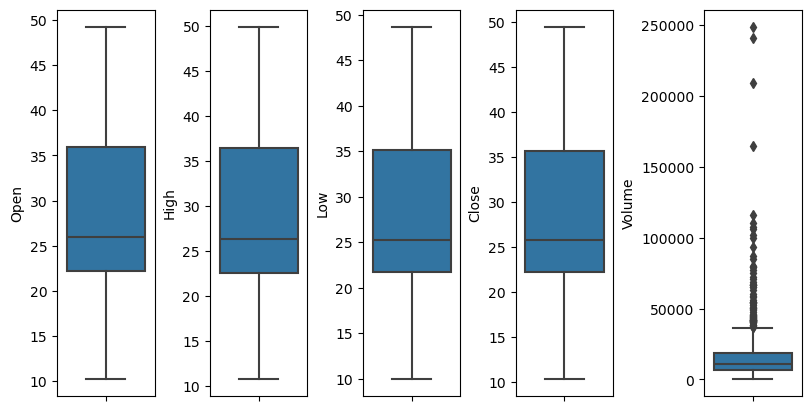

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(8, 4), layout='constrained')
for index, column_name in enumerate(['Open', 'High', 'Low', 'Close', 'Volume']) :
    sns.boxplot(
        data, y=column_name,
        ax=ax[index],
    )

/opt/miniconda3/envs/dl2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/dl2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Date', ylabel='Volume'>

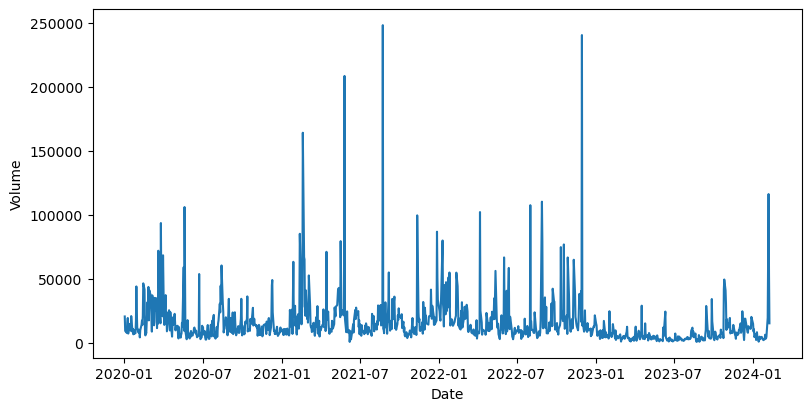

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout='constrained')
sns.lineplot(
    data=data, x='Date', y='Volume', ax=ax
)

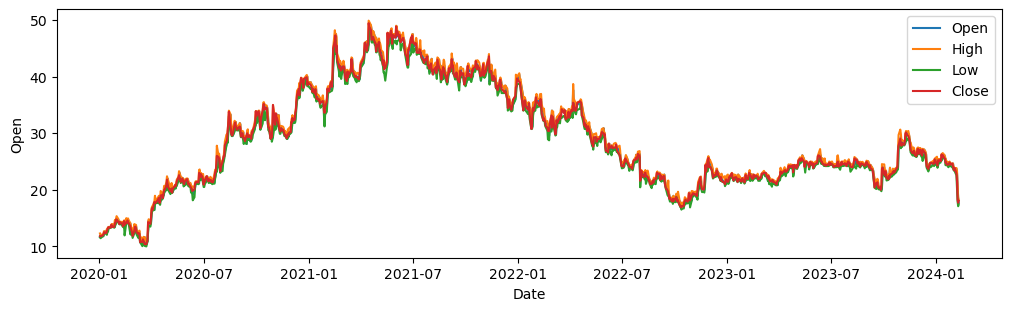

In [12]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    fig, ax = plt.subplots(1, 1, figsize=(10, 3), layout='constrained')
    for index, column_name in enumerate(['Open', 'High', 'Low', 'Close']):
        sns.lineplot(
            data, x='Date', y=column_name,
            ax=ax, label=column_name  # 
        )
            
    ax.legend(loc='upper right')  

In [13]:
# how many data point we have for each month in 2020
for month_number in range(1, 13) :
    print(
        len(
            data.where(
                (data['Date'].dt.month == month_number) & (data['Date'].dt.year == 2020)
            ).dropna()
        )
    )

21
20
22
20
19
21
23
21
22
22
21
20


# Preprocessing

In [14]:
# We can Drop `Open`, `High`, `Low` , the all follow the same shape and distribution as `Close`, and it can cause problems
data.drop(columns=['Open', 'High', 'Low'], inplace=True)

### Scaling

In [15]:
# scaling
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

data[['Close']] = min_max_scaler.fit_transform(data[['Close']])
data['Volume'] = min_max_scaler.fit_transform(data[['Volume']])

### Other

In [16]:
# we don't need the dates 
data.drop(columns=['Date'], inplace=True)

In [17]:
# split to train and test
train_size = int(len(data)*0.85)
train = data.iloc[:train_size, :]
test = data.iloc[train_size:, :]

In [18]:
data.head()

,Close,Volume
0,0.035851,0.080253
1,0.035851,0.034701
2,0.039693,0.027957
3,0.043534,0.059843
4,0.053777,0.075439


In [19]:
train

,Close,Volume
0,0.035851,0.080253
1,0.035851,0.034701
2,0.039693,0.027957
3,0.043534,0.059843
4,0.053777,0.075439
...,...,...
876,0.361076,0.003166
877,0.361076,0.007309
878,0.368758,0.003994
879,0.357234,0.001373


### Making Sequence

In [20]:
SEQUENCE_NUMBER = 7
BATCH_SIZE = 16

In [21]:
class MakeSequence(Dataset):
    def __init__(self, data, sequence_length, target):
        self.target_column_number = np.where(data.columns == target)[0][0]
        self.target = target
        self.sequence_length = sequence_length
        self.data = data.values
        self.x, self.y = self._transform()

    def _transform(self):
        x = self._make_sequence()
        y = self._make_y(x)
        # Remove the last input sequence as it has no corresponding target
        x = x[:-1]
        return x, y

    def _make_sequence(self):
        sequenced_data = np.lib.stride_tricks.sliding_window_view(self.data, window_shape=(self.sequence_length, self.data.shape[1]))
        sequenced_data = np.squeeze(sequenced_data)
        return sequenced_data
    
    def _make_y(self, x):
        return x[1:, :, self.target_column_number]

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index], dtype=torch.float)
        y = torch.tensor(self.y[index], dtype=torch.float)
        return x, y

In [22]:
train_data = MakeSequence(train, SEQUENCE_NUMBER, target='Close')
test_data = MakeSequence(test, SEQUENCE_NUMBER, target='Close')

In [23]:
# dataloader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, # ! set it to True, the results become pretty good!
    drop_last=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
)

# Modeling

In [24]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x, h_0, c_0):
        '''
            x : input X data 
            h_0 : hidden state (short-term memory)
            c_0 : cell state (long-term memory)
        '''
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.linear(output[:, -1, :])
        return output, (h_n, c_n)

In [26]:
HIDDEN_SIZE = 64
NUM_LAYERS = 4
INPUT_SIZE = 2
LR = 0.001
EPOCH = 6

To make sure you are inputting the right data shape into the model, checkout <a href='https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html'> torch </a> docs about LSTM input dims :  


In [27]:
model = LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train loop
train_loss_values = []
test_loss_values = []
for epoch in range(EPOCH):
    train_batch_loss_values = 0
    model.train()
    for batch, (x, y) in enumerate(train_dataloader):
        # x shape -> (BATCH_SIZE, SEQUENCE_LENGTH, INPUT_SIZE)
        # x = x.permute(1, 0).unsqueeze(dim=0) 
        x = x.to(device)
        y = y.to(device)

        h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        output, (h_n, c_n) = model(x, h_0, c_0)
        loss = criterion(output.squeeze(dim=0), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_batch_loss_values += loss.item()

    # evaluate on test dataset
    model.eval()
    test_batch_loss_values = 0
    with torch.inference_mode():
        for x, y in test_dataloader:
            # x = x.permute(1, 0).unsqueeze(dim=0)
            x = x.to(device)
            y = y.to(device)
            h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
            c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
            output, (h_n, c_n) = model(x, h_0, c_0)
            loss = criterion(output.squeeze(dim=0), y)
            test_batch_loss_values += loss.item()

    train_loss_values.append(train_batch_loss_values / (batch+1))
    test_loss_values.append(test_batch_loss_values / (batch+1))
    print("EPOCH:", epoch)
    print("train-loss: {0:.6f}".format(train_loss_values[epoch]))
    print("test-loss: {0:.6f}".format(test_loss_values[epoch]))

/opt/miniconda3/envs/dl2/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([16, 7])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


EPOCH: 0
train-loss: 0.050600
test-loss: 0.001552
EPOCH: 1
train-loss: 0.003651
test-loss: 0.000047
EPOCH: 2
train-loss: 0.000685
test-loss: 0.000059
EPOCH: 3
train-loss: 0.000601
test-loss: 0.000103
EPOCH: 4
train-loss: 0.000642
test-loss: 0.000073
EPOCH: 5
train-loss: 0.000553
test-loss: 0.000045


# Evaluation

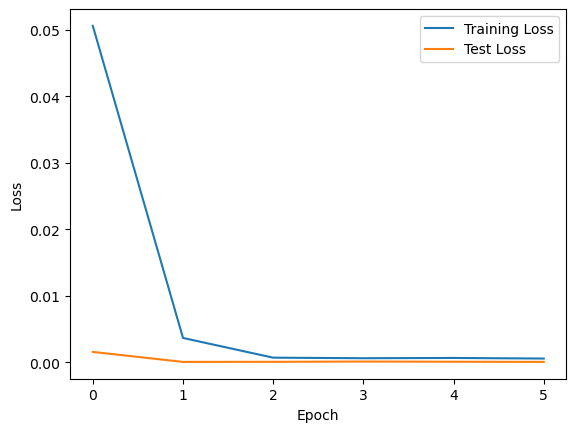

In [28]:
# plot the losses
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
model.eval()
test_predictions = []
with torch.inference_mode():
    for x, y in test_dataloader:
        x = x.to(device)
        h_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        c_0 = torch.zeros((NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float).to(device) 
        output, (h_n, c_n) = model(x, h_0, c_0)
        test_predictions.extend(output.squeeze(dim=0).cpu().numpy())


In [30]:
test_close = [y[:, 0].cpu().numpy() for x, y in test_dataloader]
test_close = np.concatenate(test_close)

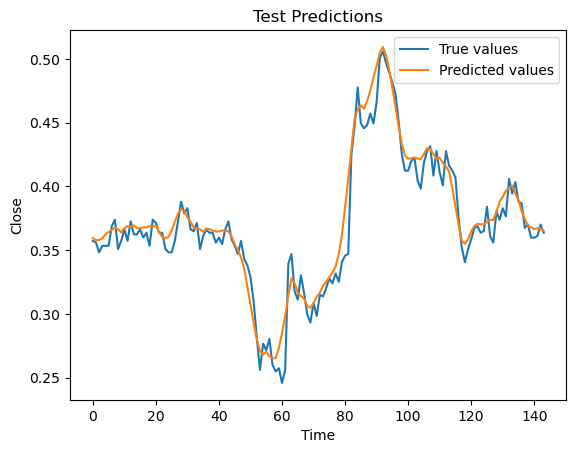

In [31]:
plt.plot(test_close, label='True values')
plt.plot(test_predictions, label='Predicted values')
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('Test Predictions')
plt.legend()
plt.show()


In [32]:
# !jupyter nbconvert --to script main.ipynb